# Logistic Regression

Predicting the likelihood that a PL outlier will be manually changed by an analyst

### Importing Libraries

In [1]:
import os

#Data Manipulation Libraries
import pandas as pd
import numpy as np

#Regression Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm

#Visualization Libraries
from matplotlib import pyplot as plt
import seaborn as sns

### Reading in the Data

In [2]:
#Checking where the Python Library is:
os.getcwd()

'C:\\Users\\cxs1rgf\\OneDrive - The Home Depot\\Desktop\\GitHub\\Outlier-Logic\\Individual\\Candice\\code'

In [3]:
df = pd.read_csv('..\data\sample_data2.csv')
df.head(1)

,PL,NW BL,Lag FC,LW Sales,LW Corr Sls,LW Manual Corr Sls,Calc?,Adjustment,Adjustment end date,Avg Price,Forecast model optimization branch,DoS PL,Outlier threshold,Sales frequency class,Region name,Product group code (level 1)
0,1003111672_8622,5.0,2.07,3.0,3.0,NaN,No,NaN,NaN,$ 599.00,02. Optimized Exp Season,S3,7.0,FQ2,SOUTH FLORIDA/PR,029A


### Creating Indicator Variables & Prepping Data

Creating Dependent Variable indicator:

If the LW Manual Corr Sls > 0 then the analyst has gone in & made a correction

1 indicates a correction was made, 0 indicates correction was not changed.

In [4]:
# remove special character
df.columns = df.columns.str.replace(' ', '_')
df.head(1)

,PL,NW_BL,Lag_FC,LW_Sales,LW_Corr_Sls,LW_Manual_Corr_Sls,Calc?,Adjustment,Adjustment_end_date,Avg_Price,Forecast_model_optimization_branch,DoS_PL,Outlier_threshold,Sales_frequency_class,Region_name,Product_group_code_(level_1)
0,1003111672_8622,5.0,2.07,3.0,3.0,NaN,No,NaN,NaN,$ 599.00,02. Optimized Exp Season,S3,7.0,FQ2,SOUTH FLORIDA/PR,029A


In [5]:
df['R'] =np.where(df['LW_Manual_Corr_Sls'] >0, 1, 0)

In [6]:
#Dropping additional variables
df.drop(['Avg_Price','PL','NW_BL','Lag_FC','LW_Sales','LW_Corr_Sls','LW_Manual_Corr_Sls','Calc?','Adjustment','Adjustment_end_date']
              , axis = 1
              , inplace = True)

Creating Independent Variables

Will need to create indicator variables for categorical variables: DoS, Forecast Optimization Model, Region Name, & Sales Frequency Class

In [33]:
cat_var = ['Sales_frequency_class','DoS_PL']

df1 = pd.get_dummies(df, columns = cat_var )
df1.head(1)

,Forecast_model_optimization_branch,Outlier_threshold,Region_name,Product_group_code_(level_1),R,Sales_frequency_class_FQ1,Sales_frequency_class_FQ2,Sales_frequency_class_FQ3,DoS_PL_S3,DoS_PL_S4,DoS_PL_S5
0,02. Optimized Exp Season,7.0,SOUTH FLORIDA/PR,029A,0,0,1,0,1,0,0


### Correlation Matrix

Checking colinearity between variables

Find that there is high correlation between SC, optimization branch, & threshold. We will remove SC & try again. This makes sense as SC groups tend to have similar optimization models which create the thresholds

We find high correlation with degree of seasonality & the outlier threshold, we will remove forecast optimization branch & outlier threshold as that is set by the degree of seasonality

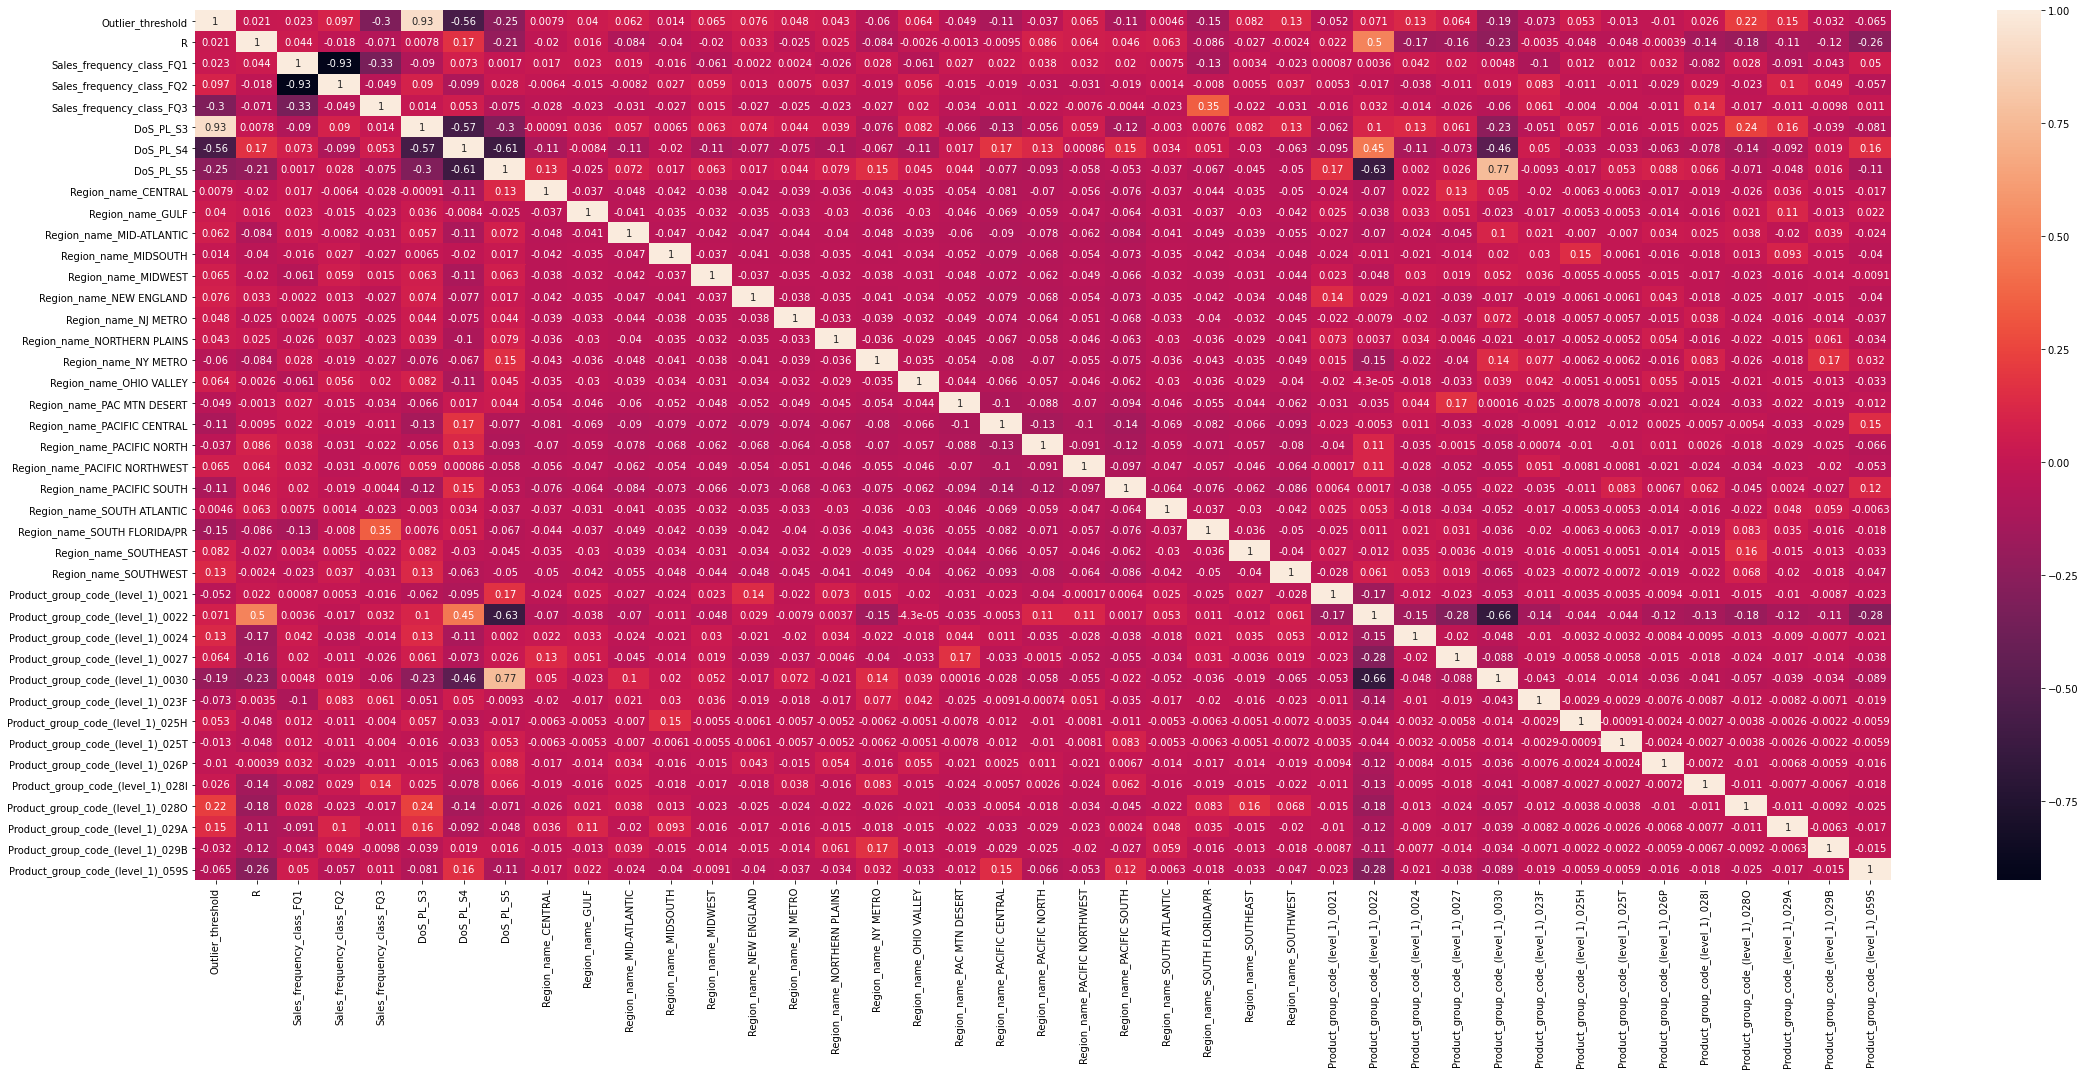

In [8]:
plt.figure(figsize = (38,16))
sns.heatmap(df1.corr(), annot = True)
plt.savefig('heatmap.png')
plt.show()

In [9]:
# def get_redundant_pairs(df2):
#     '''Get diagonal and lower triangular pairs of correlation matrix'''
#     pairs_to_drop = set()
#     cols = df2.columns
#     for i in range(0, df1.shape[1]):
#         for j in range(0, i+1):
#             pairs_to_drop.add((cols[i], cols[j]))
#     return pairs_to_drop

# def get_top_abs_correlations(df2, n=5):
#     au_corr = df2.corr().abs().unstack()
#     labels_to_drop = get_redundant_pairs(df2)
#     au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
#     return au_corr[0:n]

# print("Top Absolute Correlations")
# print(get_top_abs_correlations(df2, 20))

Top Absolute Correlations


NameError: name 'df2' is not defined

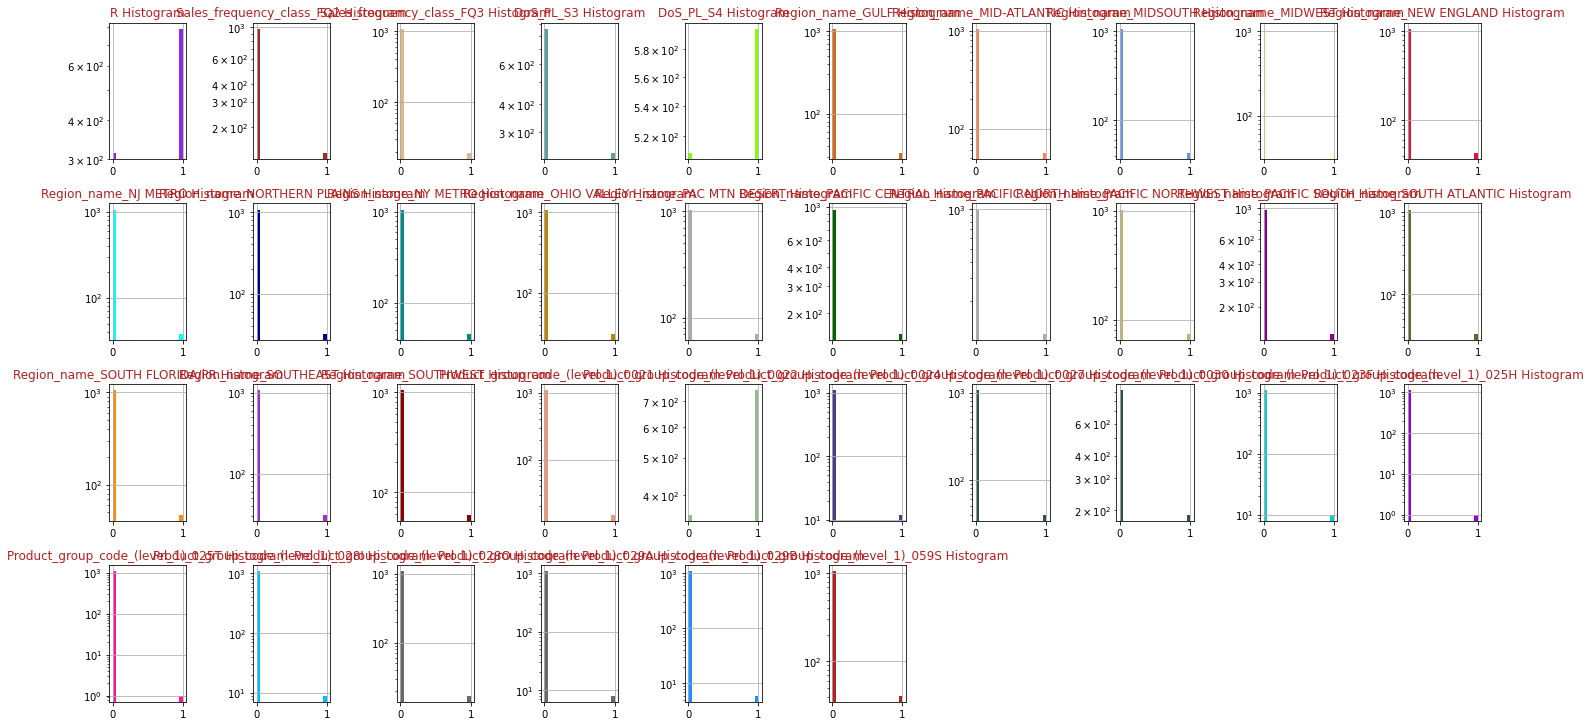

In [19]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS.keys())[10:]
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor=colors[i])
        ax.set_title(feature+" Histogram",color=colors[35])
        ax.set_yscale('log')
    fig.tight_layout() 
    plt.savefig('Histograms.png')
    plt.show()
draw_histograms(df1,df1.columns,8,10)

#### Dropping Indicator Variables

In [34]:
df1.drop(['DoS_PL_S5','Forecast_model_optimization_branch','Outlier_threshold','Region_name','Sales_frequency_class_FQ1','Product_group_code_(level_1)']
              , axis = 1
              , inplace = True)
for col in df1.columns:
    print(col)

R
Sales_frequency_class_FQ2
Sales_frequency_class_FQ3
DoS_PL_S3
DoS_PL_S4


#### Creating X & y variables

In [12]:
#turning column names into list
cols = df1.columns.tolist()

#Removing the first column name & assigning it to y_labels
y_labels = cols.pop(0)

#seting x_labels equal to the remaining columns
x_labels = cols

In [25]:
#Creating X & y variables
X = df1[x_labels]
y = df1[y_labels]

In [24]:
df1

,R,Sales_frequency_class_FQ2,Sales_frequency_class_FQ3,DoS_PL_S3,DoS_PL_S4,Region_name_GULF,Region_name_MID-ATLANTIC,Region_name_MIDSOUTH,Region_name_MIDWEST,Region_name_NEW ENGLAND,...,Product_group_code_(level_1)_0027,Product_group_code_(level_1)_0030,Product_group_code_(level_1)_023F,Product_group_code_(level_1)_025H,Product_group_code_(level_1)_025T,Product_group_code_(level_1)_028I,Product_group_code_(level_1)_028O,Product_group_code_(level_1)_029A,Product_group_code_(level_1)_029B,Product_group_code_(level_1)_059S
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1100,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1101,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1102,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Running Logistic Regression Model

Splitting into Train & Test Data

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
# X, y, test_size=0.20, random_state=5, stratify=y)

Scaling Dataset

In [ ]:
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# model.predict(X_train_scaled)

Constructing Model

In [ ]:
# model = LogisticRegression()

In [ ]:
# model.fit(X_train_scaled, y_train)

In [ ]:
train_acc = model.score(X_train_scaled, y_train)
# print("The Accuracy for Training Set is {}".format(train_acc*100))

In [ ]:
# test_acc = accuracy_score(y_test, y_pred)
# print("The Accuracy for Test Set is {}".format(test_acc*100))

In [14]:
import warnings

with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
    # Line that is not converging
#     likev = mdf.profile_re(0, dist_low=0.1, dist_high=0.1)

SyntaxError: unexpected EOF while parsing (<ipython-input-14-6a9bed54a729>, line 6)

In [15]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [26]:
df1.to_excel('test.xlsx')

In [35]:
log_reg = sm.Logit(y, X).fit(maxiter = 100)

         Current function value: inf
         Iterations: 100


C:\Users\cxs1rgf\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\cxs1rgf\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix